# Generating narrowband response

Ray tracing simulators generate outputs with arbitrarily small time and delay resolution. Using a bandwidth limited signal limits the ability to resolve different paths. This exercise shows how to generate band limited response given arbitrarily precise CIR from a ray tracing simulator.

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import wi_parser

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 16

In [3]:
# first figure out the file names
project="Boston"
studyarea="Downtown2"
projectdir="/media/adwait/44EE36CDEE36B6D0/workspace/localization/Boston"
txset434 = 17
txset905 = 16
txid = 7
rxset = 11

cir434file = wi_parser.outputfilename(project=project,
                                   studyarea=studyarea,
                                   output="cir",
                                   txset=txset434,
                                   txn=txid, 
                                   rxset=rxset, 
                                   projectdir=projectdir)

cir905file = wi_parser.outputfilename(project=project,
                                   studyarea=studyarea,
                                   output="cir",
                                   txset=txset905,
                                   txn=txid, 
                                   rxset=rxset, 
                                   projectdir=projectdir)


print("cir file 434 MHz:", cir434file)
print("cir file 905 MHz:", cir905file)

cir file 434 MHz: /media/adwait/44EE36CDEE36B6D0/workspace/localization/Boston/Downtown2/Boston.cir.t007_17.r011.p2m
cir file 905 MHz: /media/adwait/44EE36CDEE36B6D0/workspace/localization/Boston/Downtown2/Boston.cir.t007_16.r011.p2m


25 paths found for rxID 15
25 paths found for rxID 15


<IPython.core.display.Javascript object>


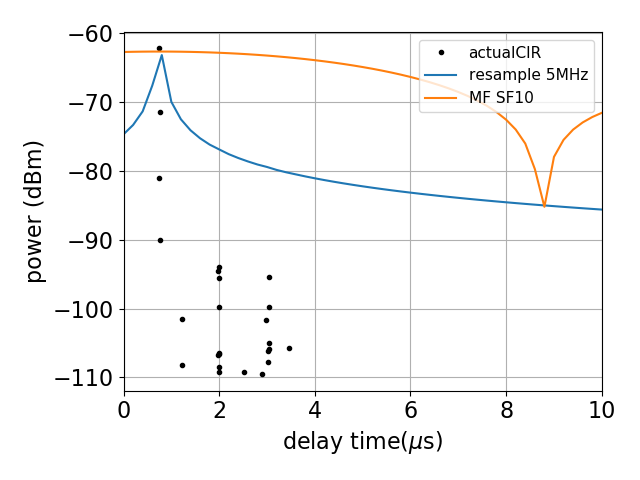

<IPython.core.display.Javascript object>


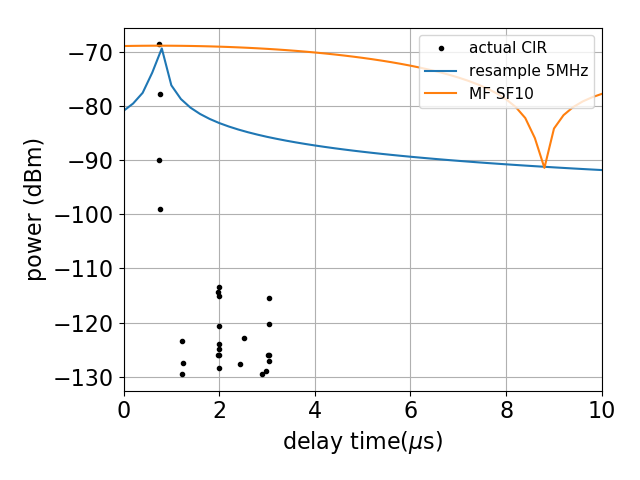

25 paths found for rxID 113
25 paths found for rxID 113


<IPython.core.display.Javascript object>


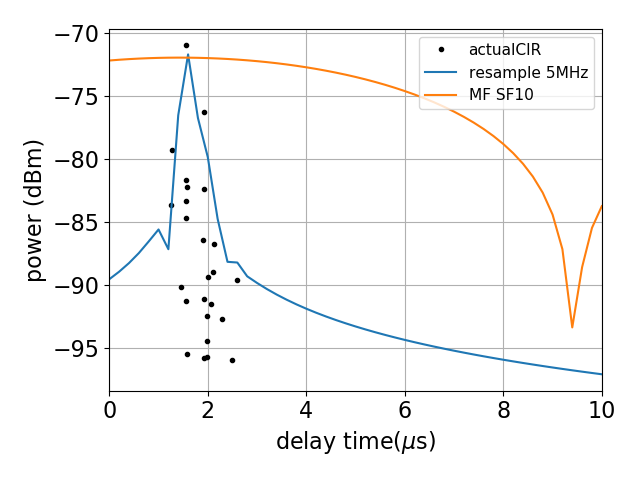

<IPython.core.display.Javascript object>


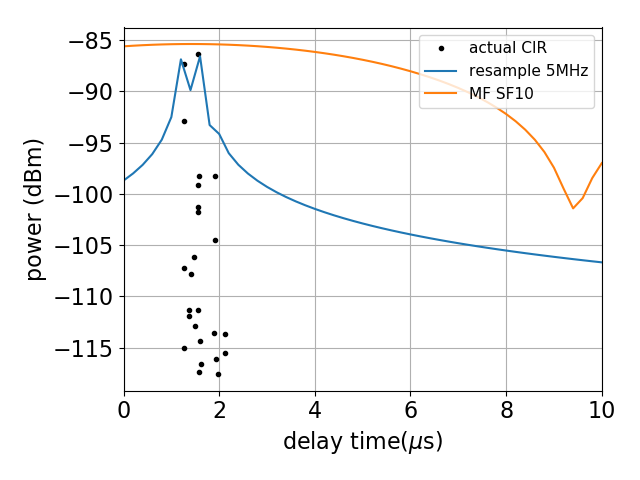

25 paths found for rxID 144
25 paths found for rxID 144


<IPython.core.display.Javascript object>


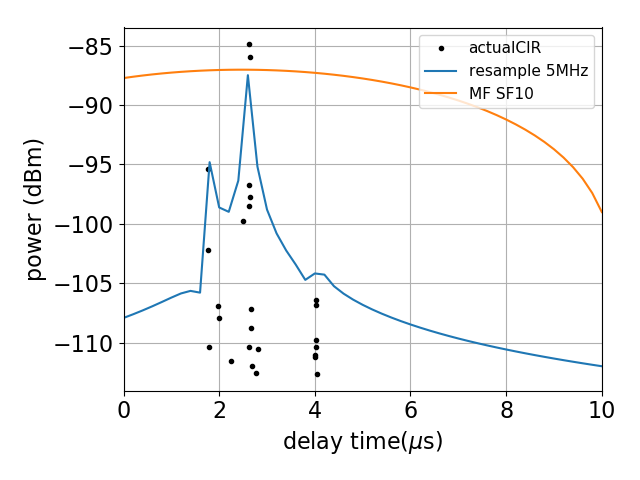

<IPython.core.display.Javascript object>


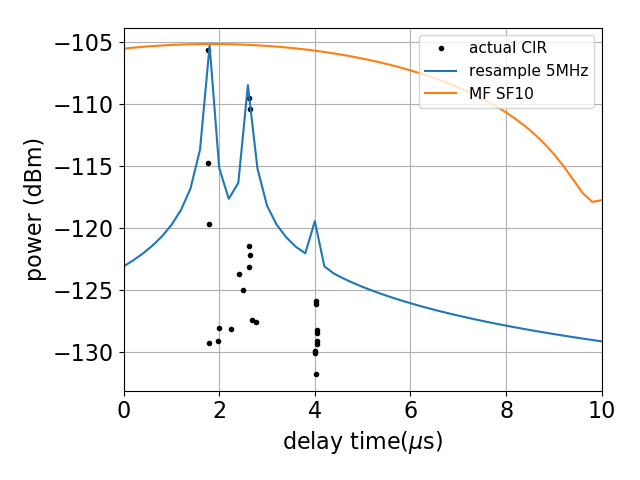

In [4]:
# get CIR for points 15, 113 and 144
rxid1 = 15
rxid2 = 113
rxid3 = 144
bw = 5e6
tend = 10e-6

# given a list of CIR enties, generate the response created by a signal and matched filter output
# this result is the ambiguity function and tells us what to expect in the received output.
def resampleAmbiguity(cirList, Ts, tEnd, sf, bw, Fd=0, tOff=0):
    tsamples = np.arange(tOff, tEnd, Ts)
    cirArray = np.zeros(tsamples.size, dtype=np.complex64)
    
    def loraSymboltime(bw, sf):
        return (2**sf)/bw
    
    def ambiguityLFMComp(t, Fd, tau, bw):
        x = np.zeros(t.shape, dtype=np.complex)
        mask = (np.abs(t) <= tau)

        def Ahat(t):
            tr = 1 - np.abs(t)/tau
            e = np.exp(1j*np.pi*Fd*t)
            return np.multiply(e, np.multiply(tr, np.sinc(np.multiply((Fd + bw*t), tr))))

        x[mask] = Ahat(t[mask])
        return x

    def tRespCIR(cirList, t, Ts):
        r = np.complex64(0.0)
        # yes, this could be optimized using some sort of map
        for cirEntry in cirList:
            toa, cir = cirEntry
            dt = t - toa
            r = r + cir*ambiguityLFMComp(dt, Fd=Fd, tau=loraSymboltime(125e3, 10), bw=125e3)
        return r

    for i,t in enumerate(tsamples):
        cirArray[i] = tRespCIR(cirList, t, Ts)
    return cirArray, tsamples

# plot the bandwidth limited version of the CIR
# output is shown in dB
def plotResampled(rxid, bw, tend, fileprefix):
    # load CIR entries for this point
    cirList434 = wi_parser.loadEntryCIR(cir434file, rxid)
    print("{} paths found for rxID {}".format(len(cirList434), rxid))
    cirList905 = wi_parser.loadEntryCIR(cir905file, rxid)
    print("{} paths found for rxID {}".format(len(cirList905), rxid))

    # convert list of CIR into array for easy plotting
    cirRaw434, tRaw434 = wi_parser.cirListToArray(cirList434)
    cirRaw905, tRaw905 = wi_parser.cirListToArray(cirList905)

    fs = bw  # complex sample sampling rate=bw
    Ts= 1/fs

    # get bandwidth limited version
    s434, t434 = wi_parser.resampleCIR(cirList434, Ts, tend)
    s905, t905 = wi_parser.resampleCIR(cirList905, Ts, tend)
    
    # get ambiguity function version (signal then matched filter)
    a434, ta434 = resampleAmbiguity(cirList434, Ts, tend, sf=10, bw=125e3)
    a905, ta905 = resampleAmbiguity(cirList905, Ts, tend, sf=10, bw=125e3)
    
    def toDb(data):
        return 10*np.log10(np.abs(data))

    plt.figure()
    plt.plot(tRaw434*1e6, toDb(cirRaw434), "k.", label="actualCIR")
    plt.plot(t434*1e6, toDb(s434), "C0-", label="resample 5MHz")
    plt.plot(ta434*1e6, toDb(a434), "C1-", label="MF SF10")
    plt.grid()
    plt.xlim([0, tend*1e6])
    plt.xlabel("delay time($\mu$s)")
    plt.ylabel("power (dBm)")
    plt.legend(fontsize='x-small', loc='upper right')
    plt.tight_layout()
    # plt.savefig("{}_mag434.pdf".format(fileprefix), format='pdf')


    plt.figure()
    plt.plot(tRaw905*1e6, toDb(cirRaw905), "k.", label="actual CIR")
    plt.plot(t905*1e6, toDb(s905), "C0-", label="resample 5MHz")
    plt.plot(ta905*1e6, toDb(a905), "C1-", label="MF SF10")
    plt.grid()
    plt.xlim([0, tend*1e6])
    plt.xlabel("delay time($\mu$s)")
    plt.ylabel("power (dBm)")
    plt.legend(fontsize='x-small', loc='upper right')
    plt.tight_layout()
    # plt.savefig("{}_mag905.pdf".format(fileprefix), format='pdf')

plotResampled(rxid=rxid1, bw=bw,tend=tend, fileprefix="results/db_rx{:d}".format(rxid1))
plotResampled(rxid=rxid2, bw=bw,tend=tend, fileprefix="results/db_rx{:d}".format(rxid2))
plotResampled(rxid=rxid3, bw=bw,tend=tend, fileprefix="results/db_rx{:d}".format(rxid3))
plt.show()